In [ ]:
%cd "C:\Users\MidAutumnFestival\Documents\DATA-255\Lab 1\part_3"

C:\Users\MidAutumnFestival\Documents\DATA-255\Lab 1\part_3


In [ ]:
import pandas as pd
from skimage.morphology import label
import gc

gc.enable()

This notebook is solely dedicated for the pre-trained model YOLO.

Pre-trained model of choice: YOLO
- It is one of the most popular objection detection model in the world with high accuracy and processing speed.

In [ ]:
# For the following few cells, we are just setting up the data just like our custom model configurations.
mask_df = pd.read_csv('train_df.csv', index_col=0)

print(mask_df.head(10))

         ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  0001b1832.jpg                                                NaN
4  00021ddc3.jpg  108287 1 109054 3 109821 4 110588 5 111356 5 1...
5  00021ddc3.jpg  101361 1 102128 3 102896 4 103663 6 104430 9 1...
6  00021ddc3.jpg  74441 3 75207 5 75975 5 76743 5 77511 5 78280 ...
7  00021ddc3.jpg  74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...
8  00021ddc3.jpg  150423 2 151190 3 151958 3 152726 4 153495 3 1...
9  00021ddc3.jpg  139644 2 140408 6 141174 9 141942 9 142711 6 1...


In [ ]:
mask_df['has_ship'] = mask_df['EncodedPixels'].isna().replace({True: 0, False: 1})

In [ ]:
count_ships = mask_df[['ImageId', 'has_ship']].groupby(by='ImageId').sum().reset_index().rename(columns={'has_ship': 'ships'})

In [ ]:
# Using an even smaller sample size because the training phase is too long and OOM issue
SAMPLES_PER_GROUP = 300
undersample_df = count_ships.groupby(by='ships').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x).reset_index(drop=True)

In [ ]:
%cd TensorFlow-2.x-YOLOv3/

C:\Users\MidAutumnFestival\Documents\DATA-255\Lab 1\part_3\TensorFlow-2.x-YOLOv3


In [ ]:
import os
import cv2
from skimage.io import imread
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from yolov3.yolov4 import Create_Yolo
from yolov3.utils import load_yolo_weights, compute_loss, read_class_names, image_preprocess, postprocess_boxes, \
    nms, detect_image, draw_bbox
from yolov3.configs import *

In [ ]:
# ref: https://www.kaggle.com/code/eigrad/convert-rle-to-bounding-box-x0-y0-x1-y1
def rle2bbox(rle, shape):
    '''
    rle: run-length encoded image mask, as string
    shape: (height, width) of image on which RLE was produced
    Returns (x0, y0, x1, y1) tuple describing the bounding box of the rle mask

    Note on image vs np.array dimensions:

        np.array implies the `[y, x]` indexing order in terms of image dimensions,
        so the variable on `shape[0]` is `y`, and the variable on the `shape[1]` is `x`,
        hence the result would be correct (x0,y0,x1,y1) in terms of image dimensions
        for RLE-encoded indices of np.array (which are produced by widely used kernels
        and are used in most kaggle competitions datasets)
    '''

    a = np.fromiter(rle.split(), dtype=np.uint)
    a = a.reshape((-1, 2))  # an array of (start, length) pairs
    a[:,0] -= 1  # `start` is 1-indexed

    y0 = a[:,0] % shape[0]
    y1 = y0 + a[:,1]
    if np.any(y1 > shape[0]):
        # got `y` overrun, meaning that there are a pixels in mask on 0 and shape[0] position
        y0 = 0
        y1 = shape[0]
    else:
        y0 = np.min(y0)
        y1 = np.max(y1)

    x0 = a[:,0] // shape[0]
    x1 = (a[:,0] + a[:,1]) // shape[0]
    x0 = np.min(x0)
    x1 = np.max(x1)

    if x1 > shape[1]:
        # just went out of the image dimensions
        raise ValueError("invalid RLE or image dimensions: x1=%d > shape[1]=%d" % (
            x1, shape[1]
        ))
    # We are using the coco class names and 8 is boat
    return f'{x0},{y0},{x1},{y1},8'

In [ ]:
from sklearn.model_selection import train_test_split

train_ids, valid_ids = train_test_split(undersample_df, test_size=0.2, stratify=undersample_df['ships'])
train_df = pd.merge(mask_df, train_ids)
valid_df = pd.merge(mask_df, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

15296 training masks
3820 validation masks


In [ ]:
def create_annotations(df, file_name):
    annotations = df.loc[~df['EncodedPixels'].isna(), ['ImageId', 'EncodedPixels']]
    annotations['ImageId'] = annotations['ImageId'].apply(lambda i: "C:\\Users\MidAutumnFestival\Documents\DATA-255\Lab 1\part_3\Train images\\{}".format(i))
    annotations['BBox'] = annotations['EncodedPixels'].apply(rle2bbox, shape=(768, 768))
    annotations = annotations[['ImageId', 'BBox']]
    annotations_group = annotations.groupby(by='ImageId')['BBox'].apply(lambda b: b.str.cat(sep=' '))
    annotations = annotations_group.reset_index()

    with open(file_name, "w") as txt_file:
        for _, s in annotations.iterrows():
            # Write bytes to file
            line = f"{s['ImageId']} {s['BBox']}\n"
            txt_file.write(line)

In [ ]:
# Create annotation files for YOLO training
create_annotations(train_df, 'ship_train.txt')
create_annotations(train_df, 'ship_test.txt')

In [ ]:
from yolov3.dataset import Dataset as YOLODataset

In [ ]:
ship_img_size = 768

In [ ]:

# Inherit from the YOLO Dataset class to use the right folder path and other configurations
class ShipDataset(YOLODataset):
    def __init__(self, dataset_type):
        super().__init__(dataset_type)

        self.annot_path = 'ship_train.txt' if dataset_type == 'train' else 'ship_test.txt'
        self.input_sizes = ship_img_size
        # Anything bigger than 1 is causing OOM
        self.batch_size = 1
        self.train_input_sizes = ship_img_size
        # Using the classes that is already there
        self.classes = read_class_names(YOLO_COCO_CLASSES)
        self.num_classes = len(self.classes)
        # This function loads annotation files' data into the dataset class
        self.annotations = self.load_annotations(dataset_type)

In [ ]:
trainset = ShipDataset('train')
testset = ShipDataset('test')

In [ ]:
# All the cells from below are referring to TensorFlow-2.x-YOLOv3\train.py
steps_per_epoch = len(trainset)
global_steps = tf.Variable(1, trainable=False, dtype=tf.int64)
warmup_steps = TRAIN_WARMUP_EPOCHS * steps_per_epoch
total_steps = 10 * steps_per_epoch

In [ ]:
if YOLO_TYPE == "yolov4":
    Darknet_weights = YOLO_V4_TINY_WEIGHTS if TRAIN_YOLO_TINY else YOLO_V4_WEIGHTS
if YOLO_TYPE == "yolov3":
    Darknet_weights = YOLO_V3_TINY_WEIGHTS if TRAIN_YOLO_TINY else YOLO_V3_WEIGHTS

Darknet = Create_Yolo(input_size=ship_img_size, CLASSES=YOLO_COCO_CLASSES)
load_yolo_weights(Darknet, Darknet_weights) # use darknet weights

yolo = Create_Yolo(input_size=ship_img_size, training=True, CLASSES=YOLO_COCO_CLASSES)

for i, l in enumerate(Darknet.layers):
    layer_weights = l.get_weights()
    if layer_weights != []:
        try:
            yolo.layers[i].set_weights(layer_weights)
        except:
            print("skipping", yolo.layers[i].name)

In [ ]:
optimizer = tf.keras.optimizers.Adam()

def train_step(image_data, target):
    with tf.GradientTape() as tape:
        pred_result = yolo(image_data, training=True)
        giou_loss = conf_loss = prob_loss = iou = 0

        # optimizing process
        grid = 3 if not TRAIN_YOLO_TINY else 2
        for i in range(grid):
            conv, pred = pred_result[i * 2], pred_result[i * 2 + 1]
            loss_items = compute_loss(pred, conv, *target[i], i, CLASSES=YOLO_COCO_CLASSES)
            # YOLOv3 uses GIOU instead of IOU as the loss function
            # GIOU is an improved IOU that it can detect bounding box that is not overlapping
            giou_loss += loss_items[0]
            # from TensorFlow-2.x-YOLOv3\yolov3\yolov4.py - compute_loss
            # if the grid contains objects, then the network output prediction box has a confidence of 1 and 0 when there is no object.
            conf_loss += loss_items[1]
            prob_loss += loss_items[2]

        total_loss = giou_loss + conf_loss + prob_loss

        gradients = tape.gradient(total_loss, yolo.trainable_variables)
        optimizer.apply_gradients(zip(gradients, yolo.trainable_variables))

        # update learning rate
        # about warmup: https://arxiv.org/pdf/1812.01187.pdf&usg=ALkJrhglKOPDjNt6SHGbphTHyMcT0cuMJg
        global_steps.assign_add(1)
        if global_steps < warmup_steps:# and not TRAIN_TRANSFER:
            lr = global_steps / warmup_steps * TRAIN_LR_INIT
        else:
            lr = TRAIN_LR_END + 0.5 * (TRAIN_LR_INIT - TRAIN_LR_END) * (
                (1 + tf.cos((global_steps - warmup_steps) / (total_steps - warmup_steps) * np.pi)))
        optimizer.lr.assign(lr.numpy())

    return global_steps.numpy(), optimizer.lr.numpy(), giou_loss.numpy(), conf_loss.numpy(), prob_loss.numpy(), total_loss.numpy()

In [ ]:
def validate_step(image_data, target):
    with tf.GradientTape() as tape:
        pred_result = yolo(image_data, training=False)
        giou_loss = conf_loss = prob_loss = iou = 0

        # optimizing process
        grid = 3 if not TRAIN_YOLO_TINY else 2
        for i in range(grid):
            conv, pred = pred_result[i*2], pred_result[i*2+1]
            loss_items = compute_loss(pred, conv, *target[i], i, CLASSES=YOLO_COCO_CLASSES)
            giou_loss += loss_items[0]
            conf_loss += loss_items[1]
            prob_loss += loss_items[2]

        total_loss = giou_loss + conf_loss + prob_loss

    return giou_loss.numpy(), conf_loss.numpy(), prob_loss.numpy(), total_loss.numpy()

In [ ]:
best_val_loss = 1000 # should be large at start
epochs = 10

# Too keep the losses for plotting
train_giou_losses, train_conf_losses, train_prob_losses = [], [], []
valid_giou_losses, valid_conf_losses, valid_prob_losses = [], [], []

for epoch in range(epochs):
    for image_data, target in trainset:
        results = train_step(image_data, target)
        cur_step = results[0] % steps_per_epoch

        print("epoch:{:2.0f} step:{:5.0f}/{}, lr:{:.6f}, giou_loss:{:7.2f}, conf_loss:{:7.2f}, prob_loss:{:7.2f}, total_loss:{:7.2f}"
                .format(epoch, cur_step, steps_per_epoch, results[1], results[2], results[3], results[4], results[5]))

    train_giou_losses.append(results[2])
    train_conf_losses.append(results[3])
    train_prob_losses.append(results[4])

    if len(testset) == 0:
        print("configure TEST options to validate model")
        yolo.save_weights(os.path.join(TRAIN_CHECKPOINTS_FOLDER, "ship_yolo_custom"))
        continue

    count, giou_val, conf_val, prob_val, total_val, iou = 0., 0, 0, 0, 0, 0
    for image_data, target in testset:
        results = validate_step(image_data, target)
        count += 1
        giou_val += results[0]
        conf_val += results[1]
        prob_val += results[2]
        total_val += results[3]

    valid_giou_losses.append(results[0])
    valid_conf_losses.append(results[1])
    valid_prob_losses.append(results[2])

    print("\n\ngiou_val_loss:{:7.2f}, conf_val_loss:{:7.2f}, prob_val_loss:{:7.2f}, total_val_loss:{:7.2f}\n\n".
            format(giou_val/count, conf_val/count, prob_val/count, total_val/count))

    if best_val_loss > (total_val / count):
        save_directory = os.path.join(TRAIN_CHECKPOINTS_FOLDER, "ship_yolo_custom")
        yolo.save_weights(save_directory)
        best_val_loss = total_val / count

epoch: 0 step:    2/250, lr:0.000000, giou_loss:  19.93, conf_loss: 141.65, prob_loss: 119.13, total_loss: 280.71
epoch: 0 step:    3/250, lr:0.000001, giou_loss:  13.82, conf_loss:  58.02, prob_loss:  21.30, total_loss:  93.13
epoch: 0 step:    4/250, lr:0.000001, giou_loss:  28.65, conf_loss: 120.40, prob_loss:  41.27, total_loss: 190.32
epoch: 0 step:    5/250, lr:0.000001, giou_loss:   3.88, conf_loss:  36.26, prob_loss:  11.93, total_loss:  52.06
epoch: 0 step:    6/250, lr:0.000001, giou_loss:  24.97, conf_loss: 103.02, prob_loss:  16.30, total_loss: 144.28
epoch: 0 step:    7/250, lr:0.000001, giou_loss:   5.77, conf_loss:  26.86, prob_loss:  16.43, total_loss:  49.05
epoch: 0 step:    8/250, lr:0.000002, giou_loss:   9.98, conf_loss:  35.33, prob_loss:   9.44, total_loss:  54.76
epoch: 0 step:    9/250, lr:0.000002, giou_loss:  29.02, conf_loss: 151.99, prob_loss:  87.30, total_loss: 268.31
epoch: 0 step:   10/250, lr:0.000002, giou_loss:   7.07, conf_loss:  62.71, prob_loss:  

In [ ]:
def rle_decode(mask_rle, shape=(ship_img_size, ship_img_size)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((ship_img_size, ship_img_size), dtype=np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

In [ ]:
def yolo_preprocess(img_path):
    original_image      = cv2.imread(img_path)
    original_image      = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    original_image      = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    image_data = image_preprocess(np.copy(original_image), [ship_img_size, ship_img_size])
    image_data = image_data[np.newaxis, ...].astype(np.float32)
    return image_data, original_image

In [ ]:
def yolo_prediction(yolo, img_data, orig_img):
    pred_bbox = yolo.predict(img_data, verbose=0)
    pred_bbox = [tf.reshape(x, (-1, tf.shape(x)[-1])) for x in pred_bbox if len(tf.shape(x)) >= 5]
    pred_bbox = tf.concat(pred_bbox, axis=0)

    bboxes = postprocess_boxes(pred_bbox, orig_img, ship_img_size, 0.3)
    bboxes = nms(bboxes, 0.45, method='nms')

    image = draw_bbox(orig_img, bboxes, CLASSES=YOLO_COCO_CLASSES, rectangle_colors=(255, 0, 0))
    return image

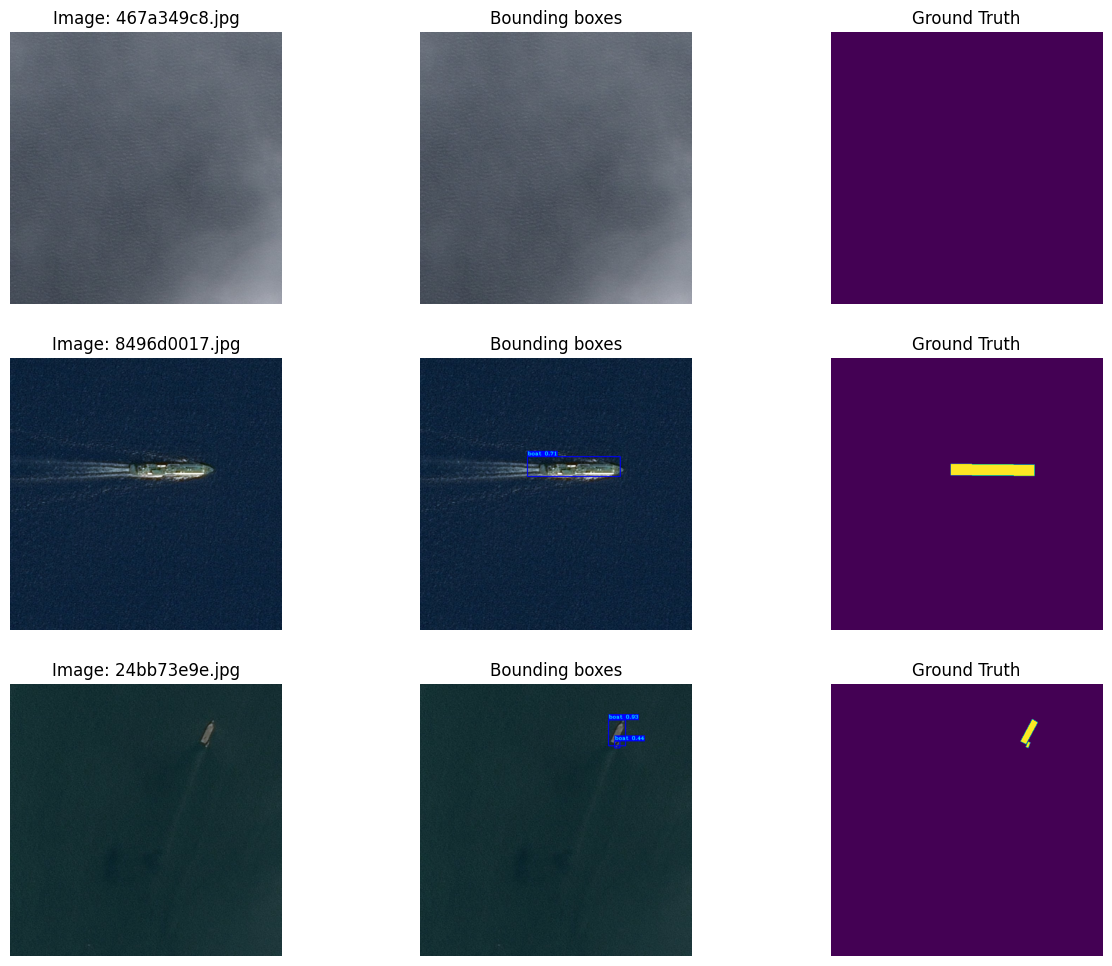

In [ ]:
samples = valid_df.query('ships < 3').groupby('ships').sample(1)
fig, axs = plt.subplots(samples.shape[0], 3, figsize=(15, samples.shape[0] * 4))
[ax.axis('off') for ax in axs.flatten()]

for (ax1, ax2, ax3), i_name in zip(axs, samples.ImageId.values):
    img_path = os.path.join('../Train images', i_name)
    img = imread(img_path)
    ax1.imshow(img)
    ax1.set_title('Image: ' + i_name)

    yolo.load_weights('checkpoints/ship_yolo_custom')
    img_data, orig_img = yolo_preprocess(img_path)
    updated_img = yolo_prediction(yolo, img_data, orig_img)
    updated_img = cv2.cvtColor(updated_img, cv2.COLOR_BGR2RGB)
    ax2.imshow(updated_img)
    ax2.set_title('Bounding boxes')

    ground_truth = masks_as_image(mask_df.query(f'ImageId == "{i_name}"')['EncodedPixels'])
    ax3.imshow(ground_truth)
    ax3.set_title('Ground Truth')

In [ ]:
train_history = pd.DataFrame({'giou': train_giou_losses, 'conf': train_conf_losses, 'prob': train_prob_losses})
valid_history = pd.DataFrame({'giou': valid_giou_losses, 'conf': valid_conf_losses, 'prob': valid_prob_losses})

In [ ]:
# Since it took too much time to run and collab might reconnect after certain time of not using it
# So storing it just in case
train_history.to_csv('Yolo_train_history.csv')
valid_history.to_csv('Yolo_valid_history.csv')

In [ ]:
train_history = pd.read_csv('Yolo_train_history.csv', usecols=['giou', 'conf', 'prob'])
valid_history = pd.read_csv('Yolo_valid_history.csv', usecols=['giou', 'conf', 'prob'])

Text(0.5, 0.98, 'Loss')

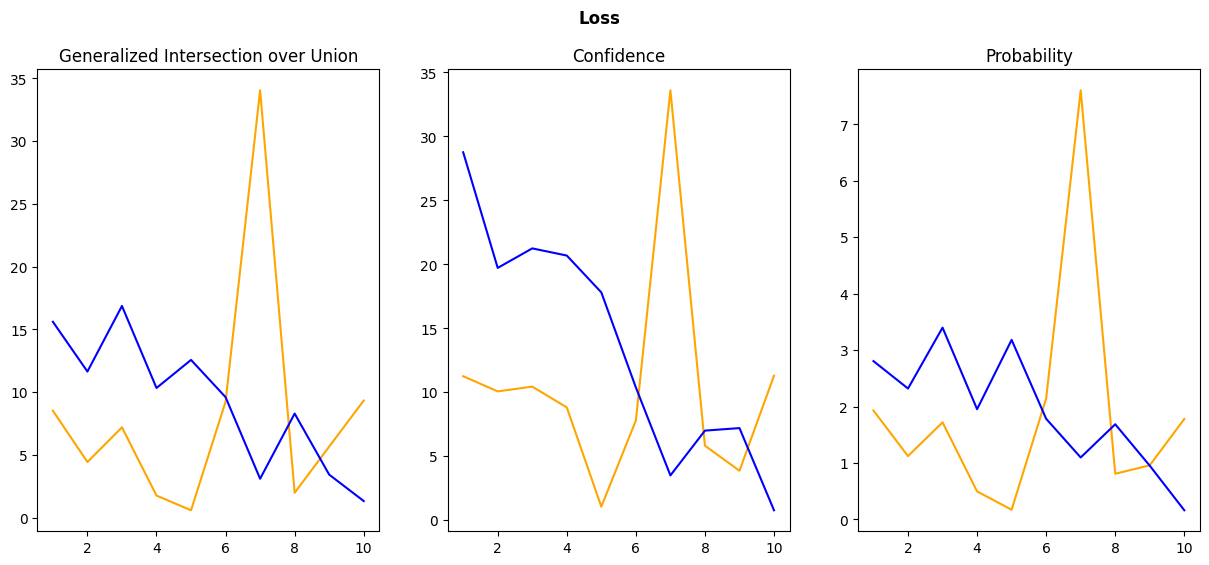

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(15, 6))

for i, c in enumerate(train_history.columns):
    epochs = train_history.index + 1
    ax[i].plot(epochs, train_history[c].values, color='orange')
    ax[i].plot(epochs, valid_history[c].values, color='blue')

ax[0].set_title('Generalized Intersection over Union')
ax[1].set_title('Confidence')
ax[2].set_title('Probability')

plt.suptitle('Loss', fontweight='bold')

In [ ]:
best_val_loss

21.9914959526062

In [ ]:
image_path   = "../Test images/"

image = detect_image(yolo, image_path, "", input_size=YOLO_INPUT_SIZE, show=False, CLASSES=TRAIN_CLASSES, rectangle_colors=(255,0,0))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(30,15))
plt.imshow(image)

In [ ]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
test_imgs = os.listdir('../Test images/')

In [ ]:
len(test_imgs)

22809

In [ ]:
def test_imgs_gtr():
    test_imgs_arr = []
    test_original_imgs_arr = []
    test_imgs_name = []
    count = 0
    while count < len(test_imgs):
        for im_name in test_imgs:
            img_path = os.path.join('../Test images/', im_name)
            # Referring to TensorFlow-2.x-YOLOv3/yolov3/utils.py detect image function
            original_image      = cv2.imread(img_path)
            original_image      = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
            original_image      = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

            image_data = image_preprocess(np.copy(original_image), [ship_img_size, ship_img_size])
            image_data = image_data[np.newaxis, ...].astype(np.float32)

            test_imgs_arr.append(image_data)
            test_original_imgs_arr.append(original_image)
            test_imgs_name.append(im_name)
            if len(test_imgs_arr) >= 1000:
                yield test_imgs_arr, test_original_imgs_arr, test_imgs_name
                test_imgs_arr = []
                test_original_imgs_arr = []
                test_imgs_name = []
            count += 1
    yield test_imgs_arr, test_original_imgs_arr, test_imgs_name

In [ ]:
ts_img_gen = test_imgs_gtr()

In [ ]:
# For this pre-trained model, I was only able to get it running on Tuesday morning and figure out how to transform bounding boxes back into RLE on Tuesday night
# We thought half of wednesday should be enough time but it is taking too much time so we stopped half way or else we won't be able to submit it
# Total inferred images from the testing folders (after some crashes and reset): 15000 / 30809

submissions = []
i = 0
first_save = False
for imgs, original_imgs, img_names in ts_img_gen:
    for data, orig, name in zip(imgs, original_imgs, img_names):
        # The printing of the number is to let me know how many images the model got to and
        # if it crashes, where to start again.
        print(i)
        # Referring to TensorFlow-2.x-YOLOv3/yolov3/utils.py detect image function
        yolo.load_weights('checkpoints/ship_yolo_custom')
        pred_bbox = yolo.predict(data, verbose=0)
        pred_bbox = [tf.reshape(x, (-1, tf.shape(x)[-1])) for x in pred_bbox if len(tf.shape(x)) >= 5]
        pred_bbox = tf.concat(pred_bbox, axis=0)

        bboxes = postprocess_boxes(pred_bbox, orig, ship_img_size, 0.3)
        bboxes = nms(bboxes, 0.45, method='nms')

        rles = []
        for b in bboxes:
            lbl = np.ceil(b[5])
            if lbl == 8.:
                mask = np.zeros((ship_img_size, ship_img_size), dtype=np.uint8)
                mask[int(np.floor(b[1])):int(np.floor(b[3])), int(np.floor(b[0])):int(np.floor(b[2]))] = 1
                rle = rle_encode(mask)
                rles.append(rle)

        if rles:
            submissions.extend([[name, rle] for rle in rles])
        else:
            submissions.append([name, np.NaN])
        i += 1

    print(f'Predicted {len(imgs)} images\' masks | Total predictions made: {i}')
    # Some garbage collection to reduce memory usage

    gc.collect()

    # Since there is no way the YOLO model can infer all the images at once (OOM after 3 - 5 thousands images)
    # storing the inference after 1000 predictions
    sub = pd.DataFrame(submissions, columns=['ImageId', 'EncodedPixels'])
    if first_save:
        sub.to_csv('yolo_submission.csv')
        first_save = False
    else:
        sub.to_csv('yolo_submission.csv', mode='a', header=False, index_label=range(i - len(imgs), i))
    submissions = []

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 

In [ ]:
sub = pd.read_csv('yolo_submission.csv')

sub.shape

(62684, 3)

In [ ]:
sub2 = pd.read_csv('yolo_submission_2.csv')

sub2.shape

(16682, 3)

In [ ]:
final = pd.concat([sub, sub2])

final.shape

final.to_csv('pre_trained_model_submission.csv')